In [3]:
import torch
import debayer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["figure.figsize"]=10,10

In [ ]:
!pip3 install -U git+https://github.com/cheind/pytorch-debayer --force -q
!pip3 install torch -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
kernels = debayer.Debayer5x5().kernels.data
kernels

tensor([[[[ 0.0000,  0.0000, -0.1250,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.2500,  0.0000,  0.0000],
          [-0.1250,  0.2500,  0.5000,  0.2500, -0.1250],
          [ 0.0000,  0.0000,  0.2500,  0.0000,  0.0000],
          [ 0.0000,  0.0000, -0.1250,  0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000,  0.0625,  0.0000,  0.0000],
          [ 0.0000, -0.1250,  0.0000, -0.1250,  0.0000],
          [-0.1250,  0.5000,  0.6250,  0.5000, -0.1250],
          [ 0.0000, -0.1250,  0.0000, -0.1250,  0.0000],
          [ 0.0000,  0.0000,  0.0625,  0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000, -0.1250,  0.0000,  0.0000],
          [ 0.0000, -0.1250,  0.5000, -0.1250,  0.0000],
          [ 0.0625,  0.0000,  0.6250,  0.0000,  0.0625],
          [ 0.0000, -0.1250,  0.5000, -0.1250,  0.0000],
          [ 0.0000,  0.0000, -0.1250,  0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000, -0.1875,  0.0000,  0.0000],
          [ 0.0000,  0.2500,  0.0000,  0.2500,  0.0000],
          [-0.1875,

In [6]:
def plot_kernel(k, ax=None):
  ax = ax or plt.gca()
  return ax.imshow(k, interpolation="nearest")


def reconstruct_kernel(k, n:int=None, min_score:float=None):
  n = n or k.shape[0]
  min_score = min_score or 1.0
  u,s,vt = torch.linalg.svd(k, full_matrices=True)
  kr = torch.zeros_like(k)
  score = 0.0
  for i in range(n):  
    kr = kr + u[:,i:i+1]*s[i]*vt[i:i+1,:]
    print(u[:, i])
    print(vt[i, :])
    print(s[i])
    score += abs(s[i])
    if score/s.abs().sum() >= min_score:
      break
  print(f'Used {i+1} singular vector(s), score {score/s.abs().sum()*100:.3f}%')
  return kr

tensor([-0.1526,  0.3051,  0.8759,  0.3051, -0.1526])
tensor([-0.1526,  0.3051,  0.8759,  0.3051, -0.1526])
tensor(0.7177)
tensor([ 0.2770, -0.5540,  0.4824, -0.5540,  0.2770])
tensor([-0.2770,  0.5540, -0.4824,  0.5540, -0.2770])
tensor(0.2177)
Used 2 singular vector(s), score 100.000%
tensor([ 0.0402, -0.1364,  0.9796, -0.1364,  0.0402])
tensor([-0.1250,  0.5347,  0.6300,  0.5347, -0.1250])
tensor(0.9797)
tensor([-0.2595, -0.6481, -0.1592, -0.6481, -0.2595])
tensor([ 0.1117,  0.4621, -0.7402,  0.4622,  0.1117])
tensor(0.1783)
Used 2 singular vector(s), score 98.105%
tensor([ 0.1250, -0.5347, -0.6300, -0.5347,  0.1250])
tensor([-0.0402,  0.1364, -0.9796,  0.1364, -0.0402])
tensor(0.9797)
tensor([-0.1117, -0.4622,  0.7402, -0.4622, -0.1117])
tensor([0.2595, 0.6481, 0.1592, 0.6481, 0.2595])
tensor(0.1783)
Used 2 singular vector(s), score 98.105%
tensor([-2.1419e-01,  0.0000e+00,  9.5302e-01,  6.8493e-09, -2.1419e-01])
tensor([-0.2142,  0.0000,  0.9530,  0.0000, -0.2142])
tensor(0.8343)


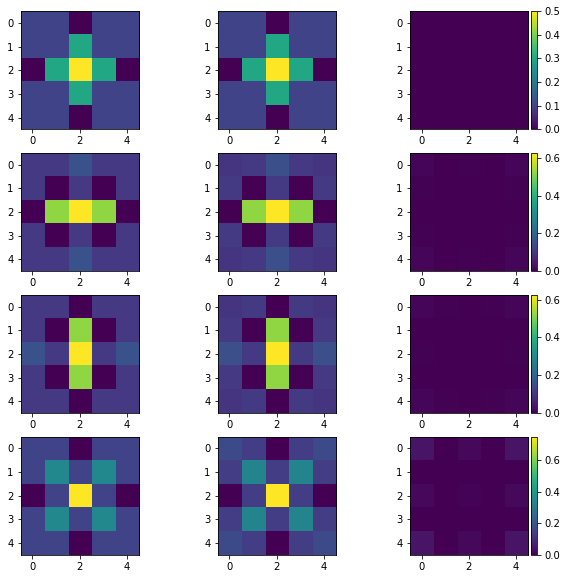

In [7]:
fig, axs = plt.subplots(4,3)

for idx in range(4):
  k = kernels[idx,0]
  kr = reconstruct_kernel(k, min_score=0.9) 
  diff = abs(k-kr)
  plot_kernel(k, axs[idx,0])
  plot_kernel(kr, axs[idx,1])
  data = axs[idx,2].imshow(diff, vmin=0, vmax=k.max())

  div = make_axes_locatable(axs[idx,2])
  cax = div.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(data, cax=cax, orientation='vertical')